C:\Users\NeilXu\AppData\Local\Temp\ipykernel_14500\1274007995.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customers_df['gender'].fillna('unknown', inplace=True)
C:\Users\NeilXu\AppData\Local\Temp\ipykernel_14500\1274007995.py:50: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

Optimization terminated successfully.
         Current function value: 0.160433
         Iterations 12
Accuracy: 0.9245
Precision: 0.8576329331046312
Recall: 0.8802816901408451
F1 Score: 0.8688097306689835
ROC AUC Score: 0.9774864269415375
                           Logit Regression Results                           
Dep. Variable:              CLV_label   No. Observations:                 8000
Model:                          Logit   Df Residuals:                     7991
Method:                           MLE   Df Model:                            8
Date:                Wed, 10 Jul 2024   Pseudo R-squ.:                  0.7314
Time:                        00:10:56   Log-Likelihood:                -1283.5
converged:                       True   LL-Null:                       -4778.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

c:\Users\NeilXu\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


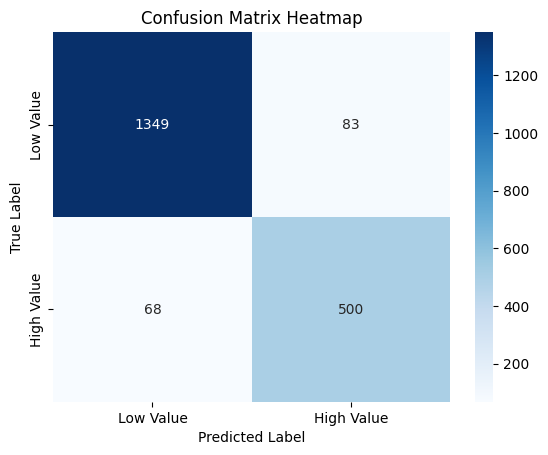

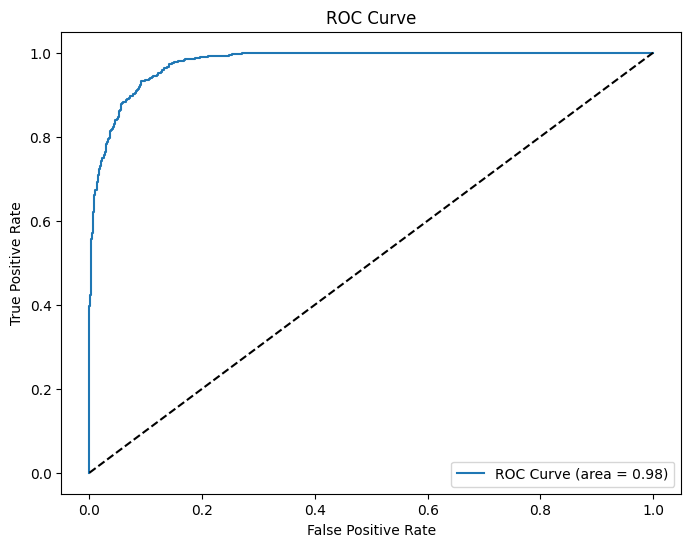

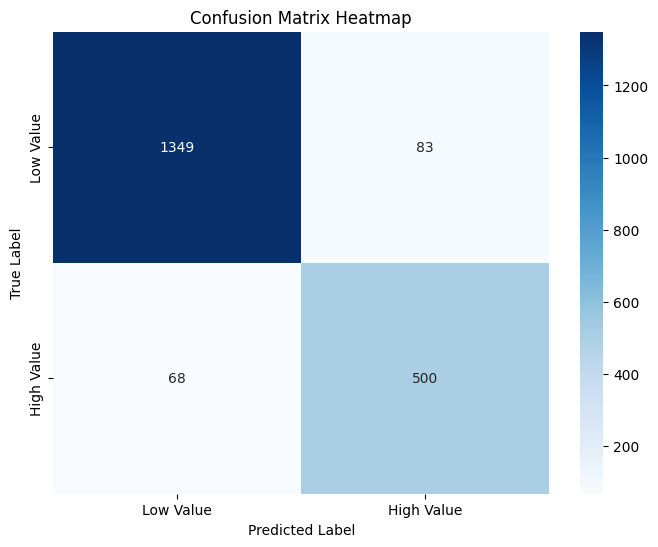

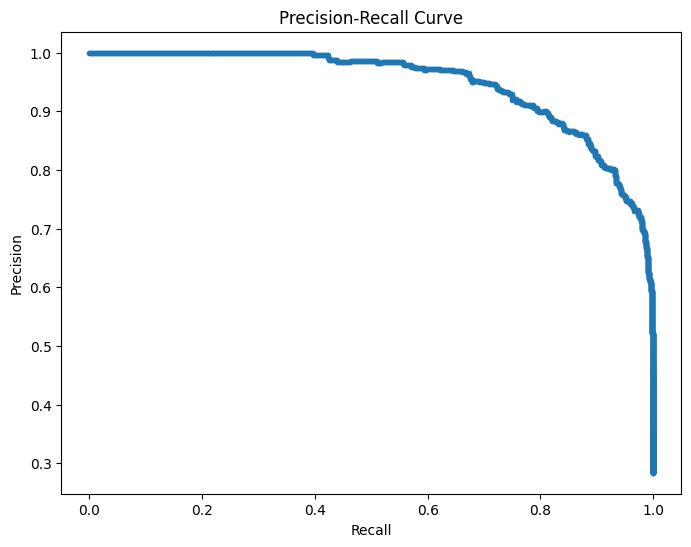

In [4]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import logit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt

# Load the datasets
customers_df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
engagements_df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing_df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')
transactions_df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')

# Data Cleaning
# Convert date columns to datetime
customers_df['join_date'] = pd.to_datetime(customers_df['join_date'])
customers_df['last_purchase_date'] = pd.to_datetime(customers_df['last_purchase_date'])
marketing_df['campaign_date'] = pd.to_datetime(marketing_df['campaign_date'])
transactions_df['transaction_date'] = pd.to_datetime(transactions_df['transaction_date'])

# Convert dates later than 7/17/2024 to 7/17/2024
cutoff_date = pd.Timestamp('2024-07-17')
customers_df['join_date'] = customers_df['join_date'].apply(lambda x: min(x, cutoff_date))
customers_df['last_purchase_date'] = customers_df['last_purchase_date'].apply(lambda x: min(x, cutoff_date))
marketing_df['campaign_date'] = marketing_df['campaign_date'].apply(lambda x: min(x, cutoff_date))
transactions_df['transaction_date'] = transactions_df['transaction_date'].apply(lambda x: min(x, cutoff_date))

# Impute 'unknown' for missing gender values
customers_df['gender'].fillna('unknown', inplace=True)

# Impute missing values in the Customers dataset using KNN for 'age'
imputer = KNNImputer(n_neighbors=5)
customers_df[['age']] = imputer.fit_transform(customers_df[['age']])

# Feature Engineering
# Calculate Recency, Frequency, and Monetary Value (RFM) features
cutoff_date = pd.Timestamp('2024-07-17')
rfm = transactions_df.groupby('customer_id').agg({
    'transaction_date': lambda x: (cutoff_date - x.max()).days,
    'transaction_id': 'count',
    'transaction_amount': 'sum'
}).reset_index()
rfm.columns = ['customer_id', 'recency', 'frequency', 'monetary']

# Calculate the number of months from join date to last purchase date
customers_df['months_since_join'] = (customers_df['last_purchase_date'] - customers_df['join_date']).dt.days / 30
customers_df['months_since_join'].replace(0, 1, inplace=True)  # Avoid division by zero
customers_df['months_since_join'] = customers_df['months_since_join'].apply(lambda x: x if x > 1 else 1)

# Define CLV using the new formula
rfm['clv'] = rfm['monetary'] / customers_df['months_since_join']

# Merge RFM data with Customers data
merged_df = customers_df.merge(rfm, on='customer_id', how='left')

# Merge with Engagements data
merged_df = merged_df.merge(engagements_df, on='customer_id', how='left')

# Calculate the number of total responses to marketing campaigns
total_responses = marketing_df.groupby('customer_id').size().reset_index(name='total_responses')

# Merge with the Marketing data
merged_df = merged_df.merge(total_responses, on='customer_id', how='left')
merged_df['total_responses'].fillna(0, inplace=True)

# Calculate the number of positive responses to marketing campaigns
positive_responses_count = marketing_df[marketing_df['response'] == 'Yes'].groupby('customer_id').size().reset_index(name='positive_responses')

# Merge with the positive responses data
merged_df = merged_df.merge(positive_responses_count, on='customer_id', how='left')
merged_df['positive_responses'].fillna(0, inplace=True)

# Feature Engineering for Engagements
# Replace 0 with 1 to avoid division by zero in frequency
merged_df['frequency'].replace(0, 1, inplace=True)

# Calculate positive responses per transaction, emails opened per transaction, clicks per transaction, and site visits per transaction
merged_df['positive_responses_per_transaction'] = merged_df['positive_responses'] / merged_df['frequency']
merged_df['emails_opened_per_transaction'] = merged_df['number_of_emails_opened'] / merged_df['frequency']
merged_df['clicks_per_transaction'] = merged_df['number_of_clicks'] / merged_df['frequency']
merged_df['site_visits_per_transaction'] = merged_df['number_of_site_visits'] / merged_df['frequency']

# Replace any remaining infinite values with NaN and drop rows with NaN in features
merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_df.dropna(subset=['positive_responses_per_transaction', 'emails_opened_per_transaction', 'clicks_per_transaction', 'site_visits_per_transaction'], inplace=True)

# Sort customers by CLV and calculate cumulative CLV
merged_df = merged_df.sort_values(by='clv', ascending=False)
merged_df['cumulative_clv'] = merged_df['clv'].cumsum()
total_clv = merged_df['clv'].sum()

# Label customers as 'high value' or 'low value'
merged_df['CLV_label'] = np.where(merged_df['cumulative_clv'] <= 0.8 * total_clv, 'High Value', 'Low Value')

# Convert CLV_label to binary
merged_df['CLV_label'] = np.where(merged_df['CLV_label'] == 'High Value', 1, 0)

# Select features and target variable for logistic regression
features = ['age', 'recency', 'frequency', 
            'positive_responses_per_transaction', 'emails_opened_per_transaction', 
            'clicks_per_transaction', 'site_visits_per_transaction', 'gender']
X = merged_df[features]
y = merged_df['CLV_label']

# One-hot encode categorical variables
X = pd.get_dummies(X, columns=['gender'], drop_first=True)

# Check for any remaining missing values in the data
X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(X.mean())

# Remove any infinite or excessively large values from the target variable
y.replace([np.inf, -np.inf], np.nan, inplace=True)
y.dropna(inplace=True)

# Align X and y to ensure the same rows
X = X.loc[y.index]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Logistic Regression model using statsmodels' logit
train_data = X_train.copy()
train_data['CLV_label'] = y_train
formula = 'CLV_label ~ age + recency + frequency + positive_responses_per_transaction + emails_opened_per_transaction + clicks_per_transaction + site_visits_per_transaction + gender_Male'
model = logit(formula=formula, data=train_data).fit()

# Make predictions on the test set using sklearn's LogisticRegression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]

# Adjust the classification threshold
threshold = 0.5  # As Default
y_pred = (y_pred_prob >= threshold).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

# Display the model summary
print(model.summary())

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Value', 'High Value'], yticklabels=['Low Value', 'High Value'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Extract feature importance and p-values
feature_importance = pd.DataFrame({
    'Feature': model.params.index,
    'Coefficient': model.params.values,
    'P-Value': model.pvalues.values
}).sort_values(by='Coefficient')

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Value', 'High Value'], yticklabels=['Low Value', 'High Value'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Plot precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [5]:
# Check the imbalance
# Calculate the distribution of the target variable
class_distribution = merged_df['CLV_label'].value_counts(normalize=True)

# Print the class distribution
print(class_distribution)


CLV_label
0    0.7155
1    0.2845
Name: proportion, dtype: float64


In [6]:
feature_importance

,Feature,Coefficient,P-Value
7,clicks_per_transaction,-3.111559,1.598055e-86
6,emails_opened_per_transaction,-1.399340,2.182243e-78
5,positive_responses_per_transaction,-0.946270,7.518589e-03
8,site_visits_per_transaction,-0.486721,4.252274e-71
1,gender_Male[T.True],-0.017874,8.596404e-01
2,age,-0.002984,3.932396e-01
3,recency,-0.000025,8.458591e-01
4,frequency,0.033591,1.459478e-04
0,Intercept,3.935753,1.193463e-51


Feature Importance:
                              Feature  Importance
5              clicks_per_transaction    3.039749
4       emails_opened_per_transaction    1.389275
3  positive_responses_per_transaction    0.846636
6         site_visits_per_transaction    0.486823
8                      gender_unknown    0.082353
2                           frequency    0.034692
7                         gender_Male    0.009642
0                                 age    0.002798
1                             recency    0.000026


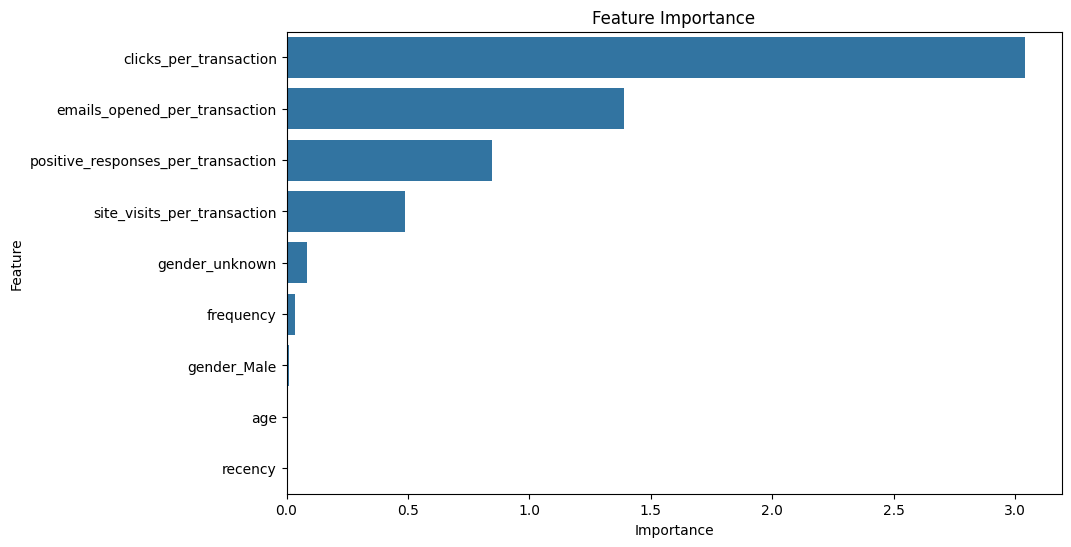

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate feature importance
feature_importance = np.abs(log_reg.coef_[0])
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

print("Feature Importance:")
print(importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()